# CLV non-contractual settings in discrete time
Based on:<br>
[Probability Models for Customer-Base Analysis](https://brucehardie.com/talks/ho_cba_tut_art_09.pdf)<br>
[Implementing the BG/BB Model for Customer-Base Analysis](http://brucehardie.com/notes/010/bgbb_spreadsheet_2011-01-20.pdf)

Hypothetical non-contractual setting:<br>
- A major public radio station located in the Midwestern
United States.
- Supported in large part by listener contributions.
- Initial focus on 1995 cohort, ignoring donation amount:
    - 11,104 people first-time supporters.
    - This cohort makes a total of 24,615 repeat donations (transactions) over the next 6 years.

What level of support (# transactions) can we expect
from this cohort in the future?

In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import beta as beta_fn
from scipy.special import gamma as gamma_fn
from scipy.special import hyp2f1
from scipy.stats import beta as beta_dist

In [2]:
v = 10 # annual contribution
d = 0.1 # annual discount rate

In [3]:
# total transactions
transactions = pd.Series(
    index=range(1996, 2007),
    data=[5652, 4674, 4019, 3552, 3555, 3163, 3110, 2938, 2703, 2573, 1936] # total n transaction
)

# transaction summary (1996-2001)
customers = pd.DataFrame(
    data = {
        'p1x': [6, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 4, 3, 2, 1, 3, 2, 1, 2, 1, 1, 0], # frequency
        'tx': [6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 2, 2, 1, 0], # recency
        'n': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], # n periods
        'donors': [1203, 728, 512, 357, 234, 129, 335, 284, 225, 173, 119, 240, \
                   181, 155, 78, 322, 255, 129, 613, 277, 1091, 3464] # n customers with given f/r pattern
    }
)
customers.head()

,p1x,tx,n,donors
0,6,6,6,1203
1,5,6,6,728
2,4,6,6,512
3,3,6,6,357
4,2,6,6,234


In [4]:
def c_BG_BB_likelihood(alpha: float,
                       beta: float,
                       gamma: float,
                       delta: float,
                       row: pd.DataFrame
                      ) -> float:
    """Conditional BG/BB likelihood
    
    Computes L(alpha, beta, gamma, delta | x, tx, n)
    
    :param alpha: BG/BB alpha
    :param beta: BG/BB beta
    :param gamma: BG/BB gamma
    :param delta: BG/BB delta
    :param row: row of customer dataframe
    
    :returns: conditional likelihood
    """
    l = 0
    l += (beta_fn(alpha+row['p1x'], beta+row['n']-row['p1x']) / beta_fn(alpha, beta)) \
    * (beta_fn(gamma, delta+row['n']) / beta_fn(gamma, delta))
    
    for j in range(row['n']-row['tx']):
        l += (beta_fn(alpha+row['p1x'], beta+row['tx']-row['p1x']+j) / beta_fn(alpha, beta)) \
            * (beta_fn(gamma+1, delta+row['tx']+j) / beta_fn(gamma, delta))
    return l


def BG_BB_likelihood(x: tuple, data: pd.DataFrame, sign: int = 1) -> float:
    """BG/BB log likelihood
    
    Computes log likelihood of BG/BB model of customer behaviour
    in discrete-time non-contractual settings.
    
    :param x: (alpha, beta, gamma, delta)
    :param row: customer dataframe
    :param sigh: multiplier of the result (scipy has no 'maximize' fn)
    
    :returns: log likelihood
    """
    alpha = x[0]
    beta = x[1]
    gamma = x[2]
    delta = x[3]
    
    log_likelihood = 0
    
    for i in range(data.shape[0]):
        row = data.iloc[i]
    
        l = c_BG_BB_likelihood(alpha, beta, gamma, delta, row)
        
        log_likelihood += row['donors'] * np.log(l)
    
    return log_likelihood * sign

In [5]:
alpha, beta, gamma, delta = minimize(BG_BB_likelihood, (1,1,1,1), args=(customers, -1), method='nelder-mead').x

In [6]:
print(f'BG/BB params:\nalpha: {round(alpha, 3)}\nbeta: {round(beta, 3)}\ngamma: {round(gamma, 3)}\ndelta: {round(delta, 3)}')

BG/BB params:
alpha: 1.204
beta: 0.75
gamma: 0.657
delta: 2.783


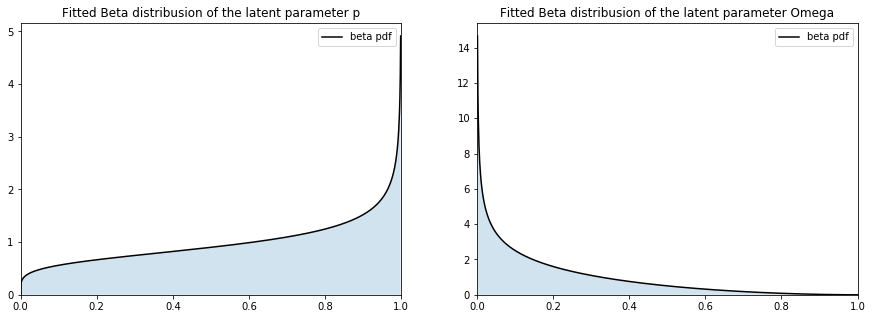

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the distribution of p
x = np.linspace(0, 1, 1000)
pdf_p = beta_dist.pdf(x, alpha, beta)

ax1.plot(x, pdf_p, label='beta pdf', color='k')
ax1.fill_between(x, 0, pdf_p, alpha=0.2)
ax1.set_title('Fitted Beta distribusion of the latent parameter p')
ax1.set_ylim(0)
ax1.set_xlim(0, 1)
ax1.legend()

# plot the distribution of omega
pdf_o = beta_dist.pdf(x, gamma, delta)

ax2.plot(x, pdf_o, label='beta pdf', color='k')
ax2.fill_between(x, 0, pdf_o, alpha=0.2)
ax2.set_title('Fitted Beta distribusion of the latent parameter Omega')
ax2.set_ylim(0)
ax2.set_xlim(0, 1)
ax2.legend()

plt.show()

In [8]:
def nCr(n,r):
    "Combination number"
    f = math.factorial
    return f(n) / f(r) / f(n-r) 


def in_sample_plot(alpha: float,
                   beta: float,
                   gamma: float,
                   delta: float,
                   data: pd.DataFrame
                  ) -> None:
    """In-Sample Model Fit Plot
    
    Compares the expected number of people making n repeat transactions 
    in the calibration sample period to the actual frequency distribution.
    
    :param alpha: BG/BB alpha
    :param beta: BG/BB beta
    :param gamma: BG/BB gamma
    :param delta: BG/BB delta
    :param row: customer dataframe
    """
    actual = customers.groupby('p1x').sum()['donors']
    predicted = []
    total = actual.sum()
    n = data['n'].max()

    for x in range(n+1):
        P_n_x = nCr(n, x) * (beta_fn(alpha+x, beta+n-x) / beta_fn(alpha, beta)) \
                            * (beta_fn(gamma, delta+n) / beta_fn(gamma, delta))
        for i in range(x, n):
            P_n_x += nCr(i, x) * (beta_fn(alpha+x, beta+i-x) / beta_fn(alpha, beta)) \
                            * (beta_fn(gamma+1, delta+i) / beta_fn(gamma, delta))
        predicted.append(P_n_x * total)
        
    res = pd.DataFrame(
        index=actual.index,
        data={
            'actual': actual,
            'model': predicted
        }
    )
    res.index.name = '# repeat transactions'
    res.plot.bar()
    plt.title('In-sample fit')
    plt.show()

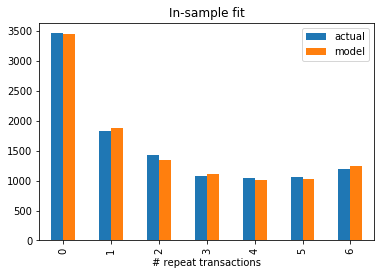

In [9]:
in_sample_plot(alpha, beta, gamma, delta, customers)

In [10]:
def tracking_plot(alpha: float,
                  beta: float,
                  gamma: float,
                  delta: float,
                  n_customers,
                  train_end,
                  transactions: pd.Series
                 ) -> None:
    """Tracking plot
    
    Assess the performance of the model is to see how well it
    tracks repeat transactions over time.
    
    :param alpha: BG/BB alpha
    :param beta: BG/BB beta
    :param gamma: BG/BB gamma
    :param delta: BG/BB delta
    :param n_customers: total number of customers
    :param train_end: last period of training sample
    :param transactions: series of number of transactions per year
    """
    predicted = []
    
    for n in range(1, len(transactions)+1):
        E_X_n = (alpha / (alpha + beta)) * (delta / (gamma - 1))
        E_X_n *= 1 - ((gamma_fn(gamma+delta) / gamma_fn(gamma+delta+n))\
                      * (gamma_fn(1+delta+n) / gamma_fn(1+delta)))
        predicted.append(E_X_n * n_customers)
        
    cumulative = pd.DataFrame(
        index=transactions.index,
        data={
            'actual': transactions.cumsum(),
            'predicted': predicted
        }
    )
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    cumulative.plot(ax=ax1)
    annual = cumulative.diff().fillna(cumulative)
    annual.plot(ax=ax2)
    
    ax1.set_title('Cumulative number of transactions')
    ax2.set_title('Annual number of transactions')
    ax1.axvline(train_end, color='k', linestyle='--', alpha=0.5)
    ax2.axvline(train_end, color='k', linestyle='--', alpha=0.5)

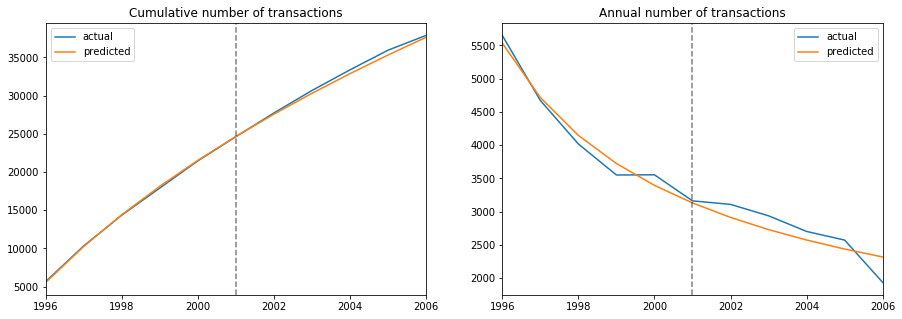

In [11]:
tracking_plot(alpha, beta, gamma, delta, customers['donors'].sum(), 2001, transactions)

In [12]:
def dert(alpha: float,
         beta: float,
         gamma: float, 
         delta: float,
         d: float,
         data: pd.DataFrame
        ) -> pd.DataFrame:
    """Discounted expected residual transactions
    
    Computes discounted expected residual transactions
    using the BG/BB model.
    
    :param alpha: BG/BB alpha
    :param beta: BG/BB beta
    :param gamma: BG/BB gamma
    :param delta: BG/BB delta
    :param d: annual discount rate
    :param data: customer dataframe
    
    :returns: dert
    """
    derts = []
    
    for i in range(data.shape[0]):
        row = data.iloc[i]
        
        dert = (beta_fn(alpha+row['p1x']+1, beta+row['n']-row['p1x']) / beta_fn(alpha, beta))
        dert *= (beta_fn(gamma, delta+row['n']+1) / beta_fn(gamma, delta)) * (1 / (1 + d))
        dert *= hyp2f1(1, delta+row['n']+1, delta+gamma+row['n']+1, (1 / (1 + d))) \
                / c_BG_BB_likelihood(alpha, beta, gamma, delta, row)
        
        derts.append(dert)
        
    res = customers.copy()
    res['dert'] = derts
        
    return res

In [13]:
customers_dert = dert(alpha, beta, gamma, delta, d, customers)
customers_dert.head()

,p1x,tx,n,donors,dert
0,6,6,6,1203,5.909882
1,5,6,6,728,5.089466
2,4,6,6,512,4.269051
3,3,6,6,357,3.448635
4,2,6,6,234,2.628219


In [14]:
RLV = pd.Series(
    data=customers_dert['dert'] * customers_dert['donors'] * v
)
print(f'RLV: {int(RLV.sum())}')

RLV: 202912
